In [1]:
import numpy as np
import pandas as pd

## Data Overview

In [2]:
pd.set_option('display.max_columns', None) #show all columns
sub = pd.read_csv('subscribers.csv')

## Data Preprocessing

In [3]:
sub = sub.drop(columns=['Unnamed: 0'])
sub.head()

,subid,package_type,num_weekly_services_utilized,preferred_genre,intended_use,weekly_consumption_hour,num_ideal_streaming_services,age,male_TF,country,attribution_technical,attribution_survey,op_sys,months_per_bill_period,plan_type,monthly_price,discount_price,account_creation_date,trial_end_date,initial_credit_card_declined,join_fee,language,payment_type,num_trial_days,current_sub_TF,payment_period,last_payment,next_payment,cancel_date,trial_completed
0,21724479,economy,NaN,comedy,access to exclusive content,NaN,NaN,NaN,False,UAE,facebook,facebook,Android,4,base_uae_14_day_trial,4.7343,4.5141,2020-01-24 21:44:16,2020-02-07 21:44:16,False,NaN,ar,Standard Charter,14,True,1,2020-02-07 21:44:16,2020-06-07 21:44:16,NaN,True
1,23383224,base,NaN,comedy,access to exclusive content,22.951579,NaN,70.0,False,UAE,facebook,facebook,NaN,4,base_uae_14_day_trial,4.7343,4.5141,2020-03-01 15:44:35,2020-03-15 15:44:35,False,0.3303,ar,NaN,14,True,1,2020-03-15 15:44:35,2020-07-15 15:44:35,NaN,True
2,26844789,enhanced,3.0,regional,replace OTT,36.001186,2.0,25.0,True,UAE,organic,facebook,iOS,4,base_uae_14_day_trial,4.7343,4.5141,2019-12-07 16:37:06,2019-12-21 16:37:06,False,0.1101,ar,NaN,14,False,0,NaN,NaN,NaN,True
3,29417030,base,NaN,drama,replace OTT,20.051667,NaN,30.0,False,UAE,search,tv,Android,4,base_uae_14_day_trial,4.7343,4.5141,2020-01-27 16:09:32,2020-02-10 16:09:32,False,0.0367,ar,NaN,14,False,0,NaN,NaN,NaN,True
4,26723159,base,4.0,comedy,replace OTT,22.951579,3.0,28.0,False,UAE,discovery,youtube,iOS,4,base_uae_14_day_trial,4.7343,4.5141,2019-10-05 12:57:07,2019-10-19 12:57:07,False,0.0367,ar,NaN,14,True,2,2020-02-19 12:57:07,2020-06-19 12:57:07,NaN,True


In [4]:
sub['current_sub_TF'].value_counts()

True     130250
False     97378
Name: current_sub_TF, dtype: int64

### Variables that can represent marketing strategies

In [5]:
#Duration of trial days (only two variables: don't count in the future)
sub['num_trial_days'].value_counts()

14    227458
0        170
Name: num_trial_days, dtype: int64

In [6]:
#Plan type: low/high price
sub['plan_type'].value_counts()

base_uae_14_day_trial                227096
high_uae_14_day_trial                   325
low_uae_no_trial                        167
base_eur_14_day_trial                    18
high_sar_14_day_trial                    12
low_gbp_14_day_trial                      4
high_aud_14_day_trial                     2
low_eur_no_trial                          1
base_uae_no_trial_7_day_guarantee         1
low_sar_no_trial                          1
high_jpy_14_day_trial                     1
Name: plan_type, dtype: int64

## AB testing

In [7]:
from scipy.stats import norm

In [8]:
sub_groupA = sub[sub['plan_type']=='base_uae_14_day_trial']
sub_groupA.shape[0]

227096

In [9]:
sub_groupB = sub[sub['plan_type']=='high_uae_14_day_trial']
sub_groupB.shape[0]

325

In [10]:
sub_groupA['current_sub_TF'].value_counts()

True     130009
False     97087
Name: current_sub_TF, dtype: int64

In [11]:
sub_groupB['current_sub_TF'].value_counts()

True     179
False    146
Name: current_sub_TF, dtype: int64

In [12]:
p_hat = 179/325
p = 130009/227096
sigma_p_hat = np.sqrt((p*(1-p)/325))

In [13]:
z = (p_hat-p)/sigma_p_hat
z

-0.7913241440560812

In [14]:
p_value = norm().sf(z) #sf = 1-CDF
p_value

0.7856225686281071

In [15]:
sub_groupC = sub[sub['plan_type']=='low_uae_no_trial']
sub_groupC.shape[0]

167

In [16]:
sub_groupC['current_sub_TF'].value_counts()

False    122
True      45
Name: current_sub_TF, dtype: int64

In [17]:
p_c_hat = 45/167

In [18]:
(p_hat-p)/np.sqrt((p*(1-p)/167))

-0.5672453856783187

In [19]:
norm().sf((p_hat-p)/np.sqrt((p*(1-p)/167)))

0.7147262616886856

## Allocation by month

In [20]:
sub_pickle = pd.read_pickle('subscribers')

In [21]:
spend = pd.read_csv('channel_spend_graduate.csv')
spend.head()

,channel,date,spend_AED
0,bing,201907,400
1,display,201907,12
2,facebook,201907,9000
3,search,201907,13000
4,youtube,201907,90


In [22]:
spend.channel.value_counts()

bing        8
display     8
facebook    8
search      8
youtube     8
Name: channel, dtype: int64

In [23]:
from datetime import datetime

In [24]:
sub_all = pd.DataFrame()
sub_all['subid'] = sub_pickle.subid.copy()
sub_all['account_creation_date'] = sub_pickle.account_creation_date.apply(lambda x:pd.to_datetime(x)).copy()
sub_all['account_creation_month']= sub_all.account_creation_date.dt.year.apply(lambda x:str(x)) + sub_all.account_creation_date.dt.month.map("{:02}".format).apply(lambda x:str(x)).copy()
sub_all['attribution_technical'] = sub_pickle.attribution_technical.copy()
sub_all['attribution_survey'] = sub_pickle.attribution_survey.copy()
sub_all['revenue_net'] = sub_pickle.revenue_net.copy()

In [25]:
sub_all.head()

,subid,account_creation_date,account_creation_month,attribution_technical,attribution_survey,revenue_net
162502,21724479,2020-01-24 21:44:16,202001,facebook,facebook,NaN
380374,23383224,2020-03-01 15:44:35,202003,facebook,facebook,0.0
496617,26844789,2019-12-07 16:37:06,201912,organic,facebook,0.0
356799,29417030,2020-01-27 16:09:32,202001,search,tv,0.0
681701,26723159,2019-10-05 12:57:07,201910,discovery,youtube,0.0


In [26]:
sub_all = sub_all.loc[sub_all['attribution_technical'].isin(['bing','display','facebook','search','youtube'])]

In [27]:
attribution_technical_number_month = sub_all[['account_creation_month','attribution_technical']].value_counts().to_frame()
# attribution_survey_number_month = sub_all[['account_creation_month','attribution_survey']].value_counts().to_frame()
attribution_technical_number_month = attribution_technical_number_month.reset_index()
# attribution_survey_number_month = attribution_survey_number_month.reset_index()
attribution_technical_number_month.columns = ['date','channel','number_user']
# attribution_survey_number_month.columns = ['date','channel','number_user']

In [28]:
attribution_technical_number_month.head()

,date,channel,number_user
0,201911,facebook,12995
1,201907,facebook,10011
2,201908,facebook,9855
3,201910,facebook,9489
4,201912,facebook,9288


In [29]:
spend['date'] = spend['date'].astype('str')

In [30]:
attribution_technical_number_month = pd.merge(attribution_technical_number_month, spend, on=['date','channel'])

In [31]:
attribution_technical_number_month['CAC'] = attribution_technical_number_month['spend_AED']/attribution_technical_number_month.number_user
attribution_technical_number_month.head()

,date,channel,number_user,spend_AED,CAC
0,201911,facebook,12995,23000,1.769912
1,201907,facebook,10011,9000,0.899011
2,201908,facebook,9855,13000,1.319127
3,201910,facebook,9489,17000,1.791548
4,201912,facebook,9288,16000,1.722653


## Allocation - total

In [32]:
attribution_technical_total = sub_all[['attribution_technical']].value_counts().to_frame()

In [33]:
attribution_technical_total = attribution_technical_total.reset_index()

In [34]:
spend_total = spend.groupby('channel').sum('spend_AED')
spend_total

,spend_AED
channel,
bing,10800
display,366
facebook,113500
search,222500
youtube,8730


In [35]:
attribution_technical_total.columns = ['channel','number_user']

In [36]:
attribution_technical_total = pd.merge(attribution_technical_total, spend_total, on=['channel'])

In [37]:
attribution_technical_total['avg_CAC'] = attribution_technical_total['spend_AED']\
/attribution_technical_total['number_user']

In [38]:
attribution_technical_total

,channel,number_user,spend_AED,avg_CAC
0,facebook,80251,113500,1.414313
1,search,25306,222500,8.792381
2,display,1407,366,0.260128
3,bing,1146,10800,9.424084
4,youtube,913,8730,9.561884


In [39]:
attribution_technical_number_month.head()

,date,channel,number_user,spend_AED,CAC
0,201911,facebook,12995,23000,1.769912
1,201907,facebook,10011,9000,0.899011
2,201908,facebook,9855,13000,1.319127
3,201910,facebook,9489,17000,1.791548
4,201912,facebook,9288,16000,1.722653


In [40]:
first_quarter = attribution_technical_number_month.loc[(attribution_technical_number_month['date']=='201907')\
                                      |(attribution_technical_number_month['date']=='201908')\
                                      |(attribution_technical_number_month['date']=='201909') ,:]
first_quarter['spend_AED'].sum()

85715

In [41]:
second_quarter = attribution_technical_number_month.loc[(attribution_technical_number_month['date']=='201910')\
                                      |(attribution_technical_number_month['date']=='201911')\
                                      |(attribution_technical_number_month['date']=='201912') ,:]
second_quarter['spend_AED'].sum()

147359

In [42]:
third_quarter = attribution_technical_number_month.loc[(attribution_technical_number_month['date']=='202001')\
                                      |(attribution_technical_number_month['date']=='202002') ,:]

#### Calculating next quarter's CAC

In [43]:
first_month = attribution_technical_number_month.loc[(attribution_technical_number_month['date']=='201907')\
                                      |(attribution_technical_number_month['date']=='201910')\
                                      |(attribution_technical_number_month['date']=='202001') ,:]
first_month_CAC = first_month.groupby('channel').sum()

In [44]:
first_month_CAC = first_month_CAC.drop(columns=['CAC'])
first_month_CAC['CAC'] =  first_month_CAC['spend_AED']/first_month_CAC['number_user']
first_month_CAC.head()

,number_user,spend_AED,CAC
channel,,,
bing,378,3600,9.523810
display,630,179,0.284127
facebook,25789,37000,1.434720
search,7734,78000,10.085337
youtube,389,4580,11.773779


In [45]:
second_month = attribution_technical_number_month.loc[(attribution_technical_number_month['date']=='201908')\
                                      |(attribution_technical_number_month['date']=='201911')\
                                      |(attribution_technical_number_month['date']=='202002') ,:]
second_month_CAC = second_month.groupby('channel').sum()

second_month_CAC = second_month_CAC.drop(columns=['CAC'])
second_month_CAC['CAC'] =  second_month_CAC['spend_AED']/second_month_CAC['number_user']
second_month_CAC.head()

,number_user,spend_AED,CAC
channel,,,
bing,477,5900,12.368973
display,505,143,0.283168
facebook,30838,50000,1.621376
search,8749,87500,10.001143
youtube,267,3150,11.797753


In [46]:
third_month = attribution_technical_number_month.loc[(attribution_technical_number_month['date']=='201909')\
                                      |(attribution_technical_number_month['date']=='201912'),:]
third_month_CAC = third_month.groupby('channel').sum()

third_month_CAC = third_month_CAC.drop(columns=['CAC'])
third_month_CAC['CAC'] = third_month_CAC['spend_AED']/third_month_CAC['number_user']
third_month_CAC.head()

,number_user,spend_AED,CAC
channel,,,
bing,112,1300,11.607143
display,124,44,0.354839
facebook,15417,26500,1.718882
search,5622,57000,10.138741
youtube,78,1000,12.820513


## Churn Model

In [47]:
df = sub.copy()

In [48]:
df['churn_TF'] = df.current_sub_TF.apply(lambda x: 1 if x == False else 0)

### Encoding 

In [49]:
# define the functions for categorization
def OTT_utilized(number):
    if number == 'Average_OTT':
        return('Average_OTT')
    else:
        number = int(number)
        if number >= 0 and number <= 2:
            return('Low_OTT')
        elif number >= 3 and number <= 5:
            return('Average_OTT')
        else: 
            return('High_OTT')
        
def hours_consumed(number):
    if number == 'Average_Consumption':
        return('Average_Consumption')
    else:
        number = int(number)
        if number < 21:
            return('Light_Consumption')
        elif number >= 21 and number < 35:
            return('Average_Consumption')
        else: 
            return('High_Consumption')

def streaming_service(number):
    if number == 'Average_Streaming':
        return('Average_Streaming')
    else:
        number = int(number)
        if number <= 1:
            return('Low_Streaming')
        elif number == 2:
            return('Average_Streaming')
        else: 
            return('High_Streaming')

def age_range(number):
    if number == 'Mid_age':
        return('Mid_age')
    else:
        number = int(number)
        if number > 1900 and number < 2020:
            number = 2020 - number
        else:
            pass
        if number <= 30:
            return('Young')
        elif number > 30 and number < 60:
            return('Mid_age')
        else: 
            return('Senior')

In [50]:
# data cleaning
# 1. "package_type" (fill_na)
df['package_type'] = df['package_type'].fillna('no_package')

# 2. "num_weekly_services_utilized" (fill_na & categorization)
df['num_weekly_services_utilized'] = df['num_weekly_services_utilized'].fillna('Average_OTT')
df['OTT_utilized'] = df['num_weekly_services_utilized'].apply(OTT_utilized)

# 3. "weekly_consumption_hour" (fill_na & categorization)
df['weekly_consumption_hour'] = df['weekly_consumption_hour'].fillna('Average_Consumption')
df['Consumption_pattern'] = df['weekly_consumption_hour'].apply(hours_consumed)

# 4. "num_ideal_streaming_services" (fill_na & categorization)
df['num_ideal_streaming_services'] = df['num_ideal_streaming_services'].fillna('Average_Streaming')
df['Streaming_pattern'] = df['num_ideal_streaming_services'].apply(streaming_service)

# 5. "age" (fill_na & categorization)
df['age'] = df['age'].fillna('Mid_age')
df['Age_group'] = df['age'].apply(age_range)

In [51]:
cleaned_col = ['subid', 'package_type', 'OTT_utilized',
               'Consumption_pattern', 'Streaming_pattern', 'attribution_technical', 
               'Age_group', 'churn_TF']
df_clean = df[cleaned_col].set_index('subid')

In [52]:
df_clean = pd.get_dummies(df_clean)
df_clean.head()

,churn_TF,package_type_base,package_type_economy,package_type_enhanced,package_type_no_package,OTT_utilized_Average_OTT,OTT_utilized_High_OTT,OTT_utilized_Low_OTT,Consumption_pattern_Average_Consumption,Consumption_pattern_High_Consumption,Consumption_pattern_Light_Consumption,Streaming_pattern_Average_Streaming,Streaming_pattern_High_Streaming,Streaming_pattern_Low_Streaming,attribution_technical_affiliate,attribution_technical_appstore,attribution_technical_bing,attribution_technical_bing_organic,attribution_technical_brand sem intent bing,attribution_technical_brand sem intent google,attribution_technical_content_greatist,attribution_technical_criteo,attribution_technical_direct_mail,attribution_technical_discovery,attribution_technical_display,attribution_technical_email,attribution_technical_email_blast,attribution_technical_facebook,attribution_technical_facebook_organic,attribution_technical_google_organic,attribution_technical_influencer,attribution_technical_internal,attribution_technical_organic,attribution_technical_other,attribution_technical_ott,attribution_technical_pinterest,attribution_technical_pinterest_organic,attribution_technical_playstore,attribution_technical_podcast,attribution_technical_quora,attribution_technical_referral,attribution_technical_samsung,attribution_technical_search,attribution_technical_tv,attribution_technical_twitter,attribution_technical_vod,attribution_technical_youtube,Age_group_Mid_age,Age_group_Senior,Age_group_Young
subid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
21724479,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
23383224,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
26844789,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
29417030,1,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
26723159,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


### Model

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import model_selection, tree

In [54]:
y = df_clean[['churn_TF']]
X = df_clean.loc[:, df_clean.columns != 'churn_TF']

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=777)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


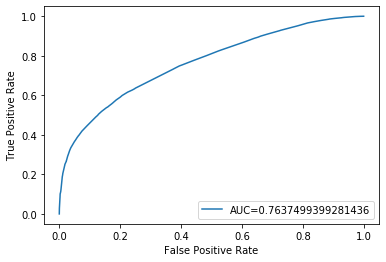

In [56]:
log_regression = LogisticRegression(max_iter=400)

# whole model
log_regression.fit(X_train,y_train)
y_pred_proba = log_regression.predict_proba(X_test)[::,1] #use predict_proba since it gives continuous outcomes
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

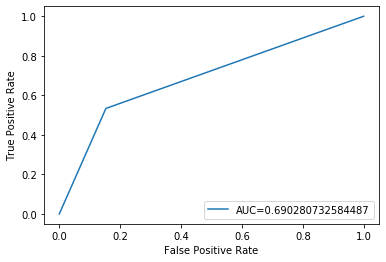

In [57]:
clf = tree.DecisionTreeClassifier(criterion='entropy') 

# whole model
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [58]:
from catboost import CatBoostClassifier

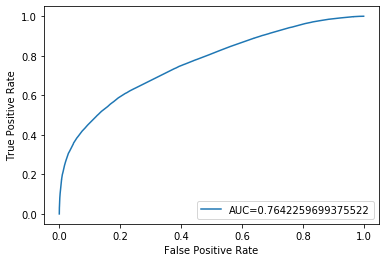

In [59]:
clf = CatBoostClassifier(
#     eval_metric = 'AUC'
    logging_level='Silent'
)

# whole model
clf.fit(X_train, y_train)

y_pred = clf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [60]:
import seaborn as sns

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [61]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(13,10))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

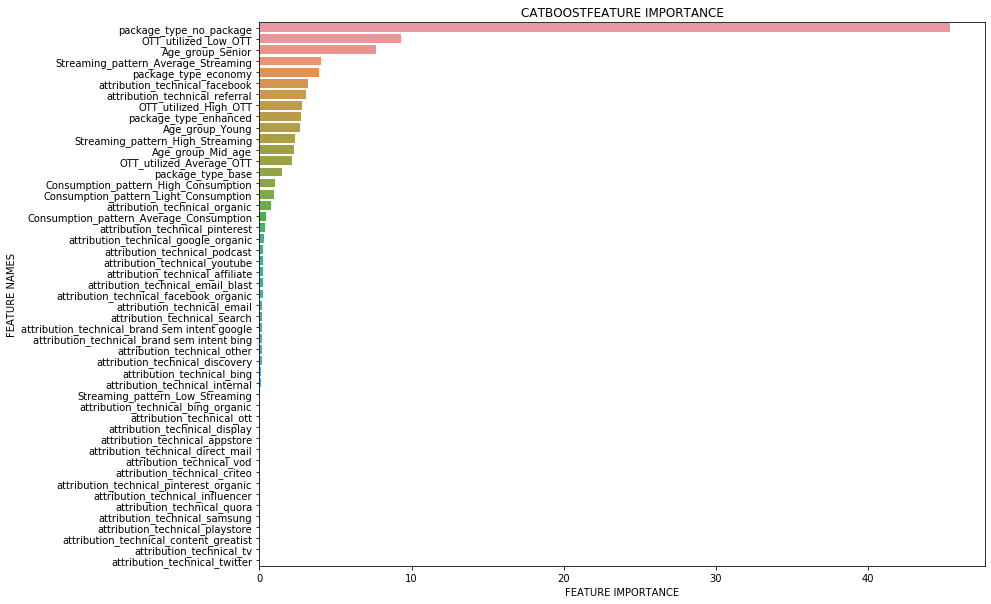

In [62]:
plot_feature_importance(clf.get_feature_importance(),X_train.columns,'CATBOOST')